# [Exp12]Newsheadline

## Library 불러오기

In [1]:
from importlib.metadata import version
import nltk
nltk.download('stopwords')

import tensorflow
import summa
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print(nltk.__version__)
print(tensorflow.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /home/aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.7
2.9.1
1.2.0


## 데이터 수집하기

In [2]:
import pandas as pd
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
pd.set_option('display.max_colwidth', -1)
data_copy = data.copy()
data.sample(10)

/tmp/ipykernel_4983/2002755332.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,headlines,text
5053,Women trying to enter Sabarimala inspired by Naxals: Swamy,"BJP MP Subramanian Swamy has said that women attempting to enter Kerala's Sabarimala temple are inspired by Naxal forces ""who hate Hinduism"". ""Today, there is fear of turmoil...Action should be taken by the communist government,"" he added. On Sunday, a group of 11 women, who tried to enter the shrine, returned from Pamba base camp amid rising protests."
15125,"8-year-old killed, 10 injured in explosion in Kolkata","An eight-year-old boy died and around 10 people were injured in an explosion that took place outside a building that houses the office of South Dum Dum Municipality Chairman Pachu Roy in Kolkata's Nagerbazar on Tuesday. ""It was a pre-planned blast. They had planned to kill me,"" RoyÃÂ claimed. The police said the cause of the explosion is being investigated."
80744,Trump hints at changing position on Paris climate deal,"US President Donald Trump on Thursday suggested that he could change his position on the Paris climate deal, after talks with his French counterpart Emmanuel Macron. ""We will talk about that over the coming period of time and if it happens that will be wonderful,"" Trump said. Notably, Trump had pulled the US out of the accord in June."
74575,Death toll in Gorakhpur's BRD Medical College rises to 105,"The death toll in Gorakhpur's BRD Medical College has risen to 105 after deaths of nine more children were confirmed on Friday. Among these nine deaths, two were reported from encephalitis ward. Recently, Indian Medical Association, after confirming disruption in oxygen supply on August 10 due to non-payment, charged the then principal and the ward in-charge with negligence."
94626,Kal Penn compares US Vice-Prez to Kantaben in Kal Ho Naa Ho,"Indian-origin actor Kal Penn tweeted that US Vice President Mike Pence reminds him of the character Kantaben from 2003 film 'Kal Ho Naa Ho'. Kantaben was portrayed as a ""homophobic"" character in the film who would feel uncomfortable on seeing Shah Rukh Khan and Saif Ali Khan's characters together. Meanwhile, Pence has often been criticised for opposing gay rights."
40150,UK gets its first airport therapy dog to calm passengers,"The United Kingdom has got its first-ever airport therapy dog to calm passengers traveling to and from the Aberdeen International Airport in Scotland. The airport has kept an Alaskan malamute named Harley, who is seen walking in the airport alongside owner Niel Chisholm. Harley, who was first introduced in March on trial, will be returning to the airport in July."
70972,Indo-Canadian Sikh politician reacts to racism with 'love',"During a recent public event, Indo-Canadian Sikh politician Jagmeet Singh was racially abused by a woman. Singh responded to it with ""love and courage"" chants, saying, ""We don't want to be intimidated by hate. We welcome you and love you."" ""Growing up as a brown-skinned, turbaned man, I faced things like this before, we can deal with it,"" Singh added."
22926,"Equal number of Muslims, Hindus left out of NRC: BJP leader","BJP leader Kabindra Purkayastha has said it his ""idea"" that an equal number of Muslims and Hindus in Assam were excluded from National Register of Citizens' (NRC) final draft. ""It is propaganda that there are more Muslims or more Hindus,"" he added. His remarks come even as NRC Coordinator Prateek Hajela said they don't have data on applicants' religion."
26939,World's 3 richest persons are now technology billionaires,"The three richest persons in the world, Jeff Bezos, Bill Gates and Mark Zuckerberg, are technology billionaires leading their companies Amazon, Microsoft and Facebook respectively. Facebook Co-Founder and CEO Mark Zuckerberg on Saturday overtook Berkshire Hathaway's Warren Buffett to become the world's third-richest person. Zuckerberg has a net worth of $81.6 billion as per Bloomberg."
65897,K'taka CM mulling legal action over BJP's scam allegation,"Karnataka Chief Minister Siddaramaiah is 

In [4]:
data.describe()

,headlines,text
count,98401,98401
unique,98280,98360
top,Warne produced 'ball of century' with his 1st Ashes delivery,"Virender Sehwag was captaining India when he hit 219 runs against Windies on December 8, 2011, becoming the second cricketer after Sachin Tendulkar to score a double hundred in ODIs. Sehwag's 219(149) is the highest individual score by a captain in ODI cricket history. Sehwag's knock helped India pile up their highest ODI total of 418/5."
freq,3,2


## 데이터 전처리하기(추상적 요약)

### 중복 확인 및 제거

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


* 중복 제거
* [pandas.DataFrame.drop_duplicates](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html)
* text에서만 제거합니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### NULL 확인 및 제거

* [pandas.DataFrame.isnull](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isnull.html#pandas.DataFrame.isnull)
* null 인 경우 True 아니면 False를 리턴하고 이에 대한 sum 이므로 개수가 나온다.

In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* 관측된 NULL 값이 없습니다.

* data를 복사해서 data_copy를 만듭니다.

In [8]:
data_copy = data.copy()
data_copy = data_copy['text']
data_copy

0        Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.               
1        Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.                                           
2        New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's

### 텍스트 정규화 및 불용어 제거 준비

* 정규화 사전 준비

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

* 불용어는 NLTK가 제공하는 것을 참조하겠습니다.

In [10]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

### 전처리 함수

* 텍스트 소문자화
* () 문자열 제거
* " 제거
* 약어 정규화(준말 정규화)
* 소유격 제거
* 영어 및 숫자 외 문자 공백으로 변환

In [11]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z0-9]", " ", sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

* 불용어 제거와 미제거로 나누어서 테스트

In [12]:
temp_text = "The Mumbai Police on Wednesday celebrated the 85th birthday of a woman named Lalita Subramaniam, who lives alone in the city. Police personnel, including Deputy Commissioner of Police, N Ambika, visited her residence with a cake to celebrate her birthday. The Mumbai Police first celebrated Lalita's birthday in 2016, following which they have been celebrating her birthday every year."
temp_headlines = "Mumbai Police celebrates 85th b'day of woman who lives alone"

print("text: ", preprocess_sentence(temp_text))
print("headline:", preprocess_sentence(temp_headlines, False))

text:  mumbai police wednesday celebrated 85th birthday woman named lalita subramaniam lives alone city police personnel including deputy commissioner police ambika visited residence cake celebrate birthday mumbai police first celebrated lalita birthday 2016 following celebrating birthday every year
headline: mumbai police celebrates 85th day of woman who lives alone


### 데이터에 적용

* Text
* 불용어 제거를 적용합니다.

In [13]:
clean_text = []
for sentence in data['text']:
    clean_text.append(preprocess_sentence(sentence))

* Headline
* 불용어 제거를 적용하지 않습니다.

In [14]:
clean_headlines = []
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headline 전처리 후 결과: ", clean_headlines[:5])

headline 전처리 후 결과:  ['upgrad learner switches to career in ml al with 90 salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india 12 match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


### 빈값이 있는지 확인해봅시다.

* 쉽게 하기 위해 데이터프레임에 저장
* 빈 값을 NULL 값으로 변환
* NULL 값을 확인합니다.

In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

data.replace('', np.nan, inplace=True)
data.isnull().sum()

headlines    0
text         0
dtype: int64

* 제거할 null 값이 없습니다.

## 훈련과 테스트 데이터 나누기

### 샘플의 최대 길이 정하기

* text와 headlines를 문장 단위로 나눈 뒤 개수를 세봅니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 36.375589670597805
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.569611630744205


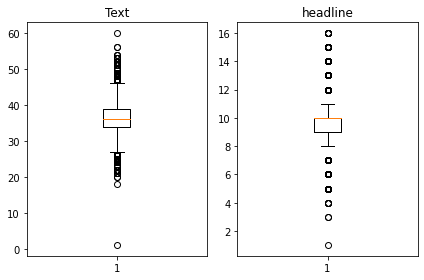

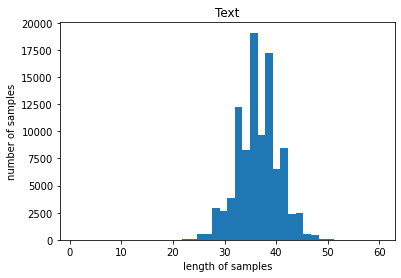

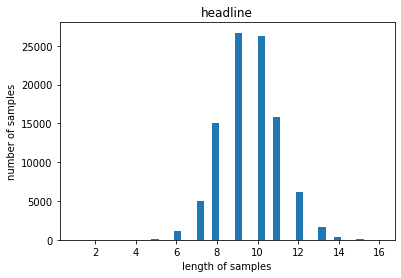

In [16]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headline_len)))
print('요약의 최대 길이 : {}'.format(np.max(headline_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headline_len)
plt.title('headline')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headline')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* Text, Summary의 적절한 최대 길이 정해보기

In [17]:
text_max_len = 40
headline_max_len = 11

In [18]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for sentence in nested_list:
        if(len(sentence.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.8522061813745425
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9163989426596177


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 76925


### 시작과 종료 토큰

* headlines 데이터에 시작과 종료 토큰을 추가합니다.

In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
3,aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save 46 800 taxes plan provides life cover age 100 years also customers options insure critical illnesses disability accidental death benefit rider life cover age 80 years,sostoken aegon life iterm insurance plan helps customers save tax,aegon life iterm insurance plan helps customers save tax eostoken
5,rahat fateh ali khan denies getting notice for smuggling currency,pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads press release issued behalf rahat statement called allegation bizarre,sostoken rahat fateh ali khan denies getting notice for smuggling currency,rahat fateh ali khan denies getting notice for smuggling currency eostoken
7,govt directs alok verma to join work day before his retirement,weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fire services post transferred removal cbi chief,sostoken govt directs alok verma to join work day before his retirement,govt directs alok verma to join work day before his retirement eostoken
9,cong wins ramgarh bypoll in rajasthan takes total to 100 seats,congress candidate shafia zubair ramgarh assembly seat rajasthan defeating bjp sukhwant singh margin 12 228 votes bypoll victory congress taken total 100 seats 200 member assembly election ramgarh seat delayed due death sitting mla bsp candidate laxman singh,sostoken cong wins ramgarh bypoll in rajasthan takes total to 100 seats,cong wins ramgarh bypoll in rajasthan takes total to 100 seats eostoken
10,up cousins fed human excreta for friendship with boys,two minor cousins uttar pradesh gorakhpur allegedly repeatedly burnt tongs forced eat human excreta family friends two boys school cousins revealed ordeal police child welfare committee brought back gorakhpur nepal fled escape torture,sostoken up cousins fed human excreta for friendship with boys,up cousins fed human excreta for friendship with boys eostoken


* Numpy로 저장

In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

## 훈련, 테스트 데이터 분리

* encoder_input 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줌

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[11257 12430 18828 ... 30790 50136 38100]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

* 카피한 원본 데이터의 index 또한 맞춰줍니다.

In [25]:
data_copy = data_copy.reindex(indices)

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15385


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

data_copy_test = data_copy[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))
print('복사 데이터 테스트 개수:', data_copy_test.shape)

훈련 데이터의 개수 : 61540
훈련 레이블의 개수 : 61540
테스트 데이터의 개수 : 15385
테스트 레이블의 개수 : 15385
복사 데이터 테스트 개수: (15385,)


## 정수 인코딩

### text 처리

In [28]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

* 단어의 등장 빈도수에 따라 나눠봅시다.
* tokenizer.word_index : 단어 집합
* tokenizer.word_counts : 단어별 빈도수
* tokenizer.word_counts.items() : 단어 : 빈도수

In [29]:
threshold = 10
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63668
등장 빈도가 9번 이하인 희귀 단어의 수: 47144
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16524
단어 집합에서 희귀 단어의 비율: 74.04661682477854
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.392576832716929


In [30]:
src_vocab = 16000
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

* texts_to_sequences() : 텍스트의 단어들을 모두 정수로 변환하는 정수 인코딩

In [31]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[159, 122, 825, 291, 848, 78, 4033, 10, 2870, 1, 291, 848, 241, 2403, 429, 41, 312, 2870, 1, 241, 395, 3966, 42, 1390, 770, 9032, 2544], [8461, 7563, 5222, 1153, 42, 13113, 377, 6731, 42, 1848, 1001, 900, 28, 252, 5, 276, 1021, 86, 7564, 41, 32, 5222, 2001, 900, 25, 234, 317, 5945, 377, 6731, 84], [326, 89, 944, 82, 742, 3, 12, 2435, 301, 514, 417, 116, 1450, 210, 581, 4247, 210, 11048, 326, 3396, 2834, 857, 301, 6, 1761, 944, 1570, 2396, 326, 3088, 3485, 12619]]


### Summary 적용

In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 9
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28865
등장 빈도가 8번 이하인 희귀 단어의 수: 21482
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 7383
단어 집합에서 희귀 단어의 비율: 74.42231075697211
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.13368093866048


* 위 값을 통해 7000정도 잡습니다.

In [34]:
tar_vocab = 7000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 393, 559, 78, 128, 2321, 206, 3, 963, 92, 1310], [1, 15, 189, 1432, 262, 4216, 13, 1843, 567], [1, 1344, 423, 1070, 7, 5189, 1631], [1, 240, 56, 182, 2368, 4, 3135, 114, 847, 53, 158], [1, 3136, 611, 378, 277, 1311, 543, 347]]
target
decoder  [[393, 559, 78, 128, 2321, 206, 3, 963, 92, 1310, 2], [15, 189, 1432, 262, 4216, 13, 1843, 567, 2], [1344, 423, 1070, 7, 5189, 1631, 2], [240, 56, 182, 2368, 4, 3135, 114, 847, 53, 158, 2], [3136, 611, 378, 277, 1311, 543, 347, 2]]


### 빈 샘플 삭제

In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 61539
훈련 레이블의 개수 : 61539
테스트 데이터의 개수 : 15385
테스트 레이블의 개수 : 15385


### 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

## 모델 설계

### Encoder

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))

enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

2022-09-02 22:55:48.849945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 22:55:48.924873: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 22:55:48.925033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-02 22:55:48.925869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Decoder

* Decoder 설계시 Encoder와 거의 유사하지만 initial_state = h ,c 로 둔다.

In [38]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

* 출력 층

In [39]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2048000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

### 모델 확인

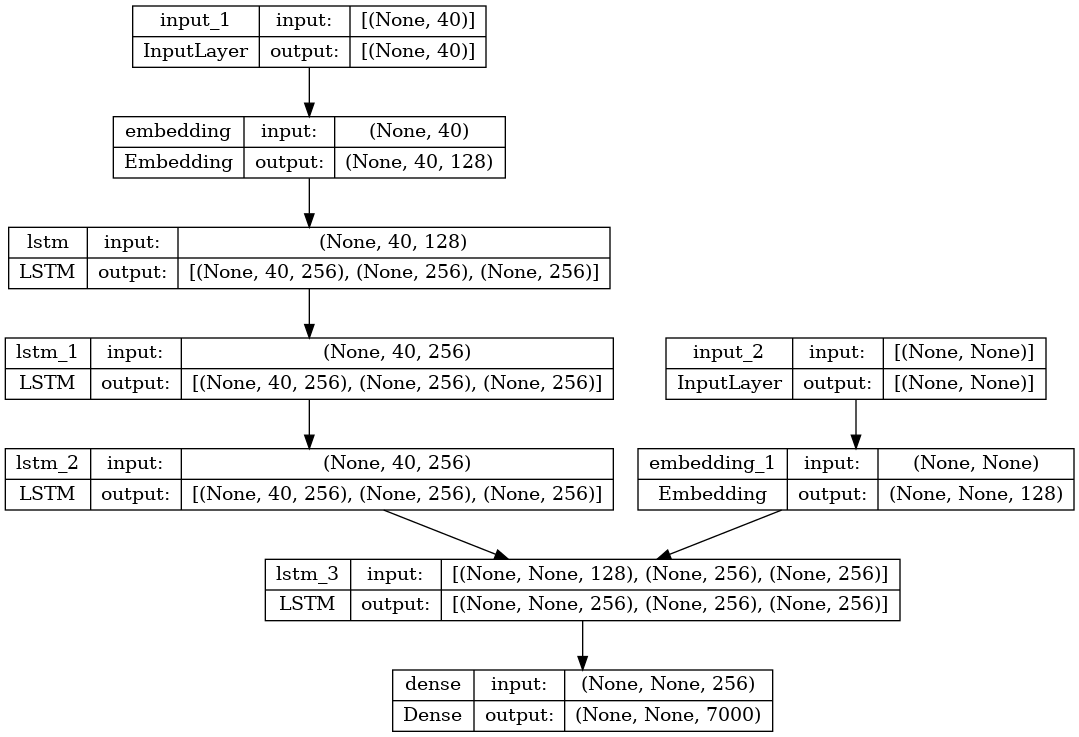

In [40]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

### Attention Mechanism

In [41]:
from tensorflow.keras.layers import AdditiveAttention

attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2048000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

## 모델 훈련

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50


2022-09-02 22:55:55.683474: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6992625664 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-09-02 22:55:57.169117: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


240/241 [============================>.] - ETA: 0s - loss: 5.8358

2022-09-02 22:56:13.031566: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 2070" frequency: 1455 num_cores: 36 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 6992625664 bandwidth: 352064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


241/241 [==============================] - 23s 65ms/step - loss: 5.8354 - val_loss: 5.4358
Epoch 2/50
241/241 [==============================] - 14s 58ms/step - loss: 5.3212 - val_loss: 5.1232
Epoch 3/50
241/241 [==============================] - 14s 58ms/step - loss: 5.0025 - val_loss: 4.8482
Epoch 4/50
241/241 [==============================] - 14s 58ms/step - loss: 4.7304 - val_loss: 4.6621
Epoch 5/50
241/241 [==============================] - 14s 58ms/step - loss: 4.5089 - val_loss: 4.4851
Epoch 6/50
241/241 [==============================] - 14s 59ms/step - loss: 4.3185 - val_loss: 4.3669
Epoch 7/50
241/241 [==============================] - 14s 59ms/step - loss: 4.1564 - val_loss: 4.2703
Epoch 8/50
241/241 [==============================] - 14s 60ms/step - loss: 4.0125 - val_loss: 4.1980
Epoch 9/50
241/241 [==============================] - 14s 60ms/step - loss: 3.8857 - val_loss: 4.1371
Epoch 10/50
241/241 [==============================] - 14s 60ms/step - loss: 3.7716 - val_los

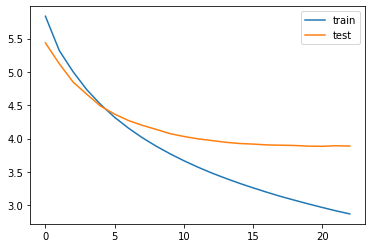

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Inference Model

### 3개의 사전 준비

In [44]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

### 모델 설계

In [45]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

### Attention Mechanism

In [46]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

### 함수 설정

In [47]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose = 0)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose = 0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

## 모델 테스트

### 정수 -> 텍스트

In [48]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
origin = []
target = []
predict = []
for i in range(50, 65):
    ex_origin = seq2text(encoder_input_test[i])
    ex_target = seq2headline(decoder_input_test[i])
    ex_predict = decode_sequence(encoder_input_test[i].reshape(1, text_max_len))
    origin.append(ex_origin)
    target.append(ex_target)
    predict.append(ex_predict)
    print("원문 :", ex_origin)
    print("실제 요약 :", ex_target)
    print("예측 요약 :", ex_predict)
    print("\n")

원문 : haryana vidhan sabha speaker kanwar pal monday expelled 15 congress mlas assembly day created ruckus demanding discussion irrigation scheme mlas continued arguing speaker despite assurance hold discussions issue also shouted anti government slogans exiting assembly 
실제 요약 : 15 congress mlas expelled from haryana assembly over chaos 
예측 요약 :  gujarat assembly speaker mlas from assembly


원문 : nthe centre sanctioned crore punjab government 100 1984 anti sikh riot victims migrated state centre earlier planned compensation november 2016 state unable rehabilitation accordance recommendations made committee led justice 
실제 요약 : centre clears crore for over 100 1984 sikh riot victims 
예측 요약 :  over crore in delhi govt


원문 : kings xi punjab player martin took single handed catch boundary dismiss mumbai indians thursday hit shot glenn maxwell bowling towards long boundary jumped took catch right hand notably maxwell delivery short ball 
실제 요약 : kxip to take one handed catch at boundary 
예

* syria, terror, asseembly 등 주요 단어들을 포함하고 있지만 생각보다 정확도가 높진 않습니다.

### 추출적 요약해보기

In [50]:
from summa.summarizer import summarize

In [64]:
predict2 = []

for i in range(50, 65):
    input = seq2text(encoder_input_test[i])
    summary = summarize(data_copy_test.iloc[i], ratio = 0.5)
    print("원문 :", input)
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("추출적 요약 :", summary)
    predict2.append(summary)
    print("\n")

원문 : haryana vidhan sabha speaker kanwar pal monday expelled 15 congress mlas assembly day created ruckus demanding discussion irrigation scheme mlas continued arguing speaker despite assurance hold discussions issue also shouted anti government slogans exiting assembly 
실제 요약 : 15 congress mlas expelled from haryana assembly over chaos 
추출적 요약 : Stating that war is not a solution to anything, former Jammu and Kashmir CM Farooq Abdullah on Monday questioned if Pakistan was the only nation firing across the border.


원문 : nthe centre sanctioned crore punjab government 100 1984 anti sikh riot victims migrated state centre earlier planned compensation november 2016 state unable rehabilitation accordance recommendations made committee led justice 
실제 요약 : centre clears crore for over 100 1984 sikh riot victims 
추출적 요약 : In an apparent reference to the Gandhi family, Prime Minister Narendra Modi on Monday said, "For the Congress, the welfare of Chhattisgarh is not a priority.


원문 : kings x

In [71]:
print(len(origin))
print(len(target))
print(len(predict))
print(len(predict2))

df_result = pd.DataFrame(data = {'원본':origin,'실제 요약': target, '추상' : predict, '추출' :predict2})
df_result

15
15
15
15


,원본,실제 요약,추상,추출
0,haryana vidhan sabha speaker kanwar pal monday expelled 15 congress mlas assembly day created ruckus demanding discussion irrigation scheme mlas continued arguing speaker despite assurance hold discussions issue also shouted anti government slogans exiting assembly,15 congress mlas expelled from haryana assembly over chaos,gujarat assembly speaker mlas from assembly,"Stating that war is not a solution to anything, former Jammu and Kashmir CM Farooq Abdullah on Monday questioned if Pakistan was the only nation firing across the border."
1,nthe centre sanctioned crore punjab government 100 1984 anti sikh riot victims migrated state centre earlier planned compensation november 2016 state unable rehabilitation accordance recommendations made committee led justice,centre clears crore for over 100 1984 sikh riot victims,over crore in delhi govt,"In an apparent reference to the Gandhi family, Prime Minister Narendra Modi on Monday said, ""For the Congress, the welfare of Chhattisgarh is not a priority."
2,kings xi punjab player martin took single handed catch boundary dismiss mumbai indians thursday hit shot glenn maxwell bowling towards long boundary jumped took catch right hand notably maxwell delivery short ball,kxip to take one handed catch at boundary,maxwell takes catch to catch,Jammu and Kashmir Police Chief on Monday said that he has heard that nobody was ready to take up the post of commander in terror group Lashkar-e-Taiba.
3,municipal elections held syria sunday first time since civil war broke country 2011 40 000 candidates competing 18 400 council seats syrian state media reported areas outside government control including kurdish held regions excluded polls,syria holds 1st local elections since the start of civil war,syrian war war rises to 20 years,"Sharing her picture with husband Virat Kohli on the occasion of their first Karvachauth on Saturday, Anushka Sharma wrote, ""My moon, my sun, my star, my everything...Happy Karvachauth to all."" Virat also shared his picture with Anushka and captioned it, ""My life."
4,russia federal security service arrested members isis cell planning high profile attacks moscow cell members planned carry attacks including blasts public places transport system september said earlier arrested four isis members august shut bomb making laboratory,isis cell planning high profile attacks arrested in russia,us arrests isis in crackdown on terror attack,"US President Donald Trump's recent ""harsh"" statements against Pakistan had led to a decline in the relationship, he added."
5,russia deploy disputed island near japan russian pm dmitry allowed nation air force use civilian airport island part group four russian occupied islands seized end wwii japan termed russia move attempt increase military power islands,russia to deploy on island near japan,russia deploys russian military base in ukraine,"Japanese crypto exchange Coincheck, which lost about $530 million after suffering the world's largest cryptocurrency hack ever, was acquired by online brokerage firm Monex Group for about $34 million."
6,union steel minister chaudhary singh friday said joint venture steel authority india signed soon technology keen sail added said proposed 15 000 crore automotive steel plant come andhra pradesh,joint venture between soon minister,india to be the commerce of the year,Hindi poet Kedarnath Singh on Monday passed away at the age of 83 in New Delhi after a prolonged illness.
7,banned australian cricketer steve smith friday took instagram reveal returned australia spending time away come terms everything lot earn back trust wrote smith serving one year ban involvement ball tampering scandal south africa,have lot to do to earn back your trust steve smith,got life for the time of ipl 2017,France took the lead in the 30th minute before Sarangapani Raman scored India's first-ever international goal in the 70th minute.
8,north korea warned us allies pursue sanctions faster complete development nucle

* 문법 완성도는 추출이 더 높으나 핵심 단어는 추출보단 추상 쪽에 있는 경우가 많습니다.

## 회고

* 이번 프로젝트에서 어려웠던 점
    - 번역기가 생각보다 제대로 작동하지 않았습니다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - dataframe은 set_index, series는 reindex를 사용해서 index를 재설정합니다.
  * 아직 모호한 점
    - 모델의 어떤 부분을 수정해야 번역기의 성능이 올라가는가?
* 루브릭 평가를 맞추기 위해 시도한 점
    - 데이터를 복사하여 사용하였습니다.
    - 데이터프레임을 새롭게 만들어서 출력하였습니다.